# Lecture 6, Data science in Neuroscience

## Plan for today

1. Graphical overview of what we have done so far
2. Analysis of spatially selective neurons
    1. Loading spike trains and position data.
    2. Analysis on spike trains (mean firing rate, instantaneous firing rate)
    3. Analysis on position data
    4. Firing rate map of neurons


To manipulate the data, we will use 3 main techniques:

1. Histograms
2. Gaussian filters
3. Linear interpolations

***

## Graphical overview

### Spike detection from filtered signals


* The signal was first filtered and we detected negative deflections as spikes. 
* The time associated with each spike was saved. 
* We extracted the waveform of each spike for clustering.

<div>
<img src="../images/spike_detection.png" width="1200"/>
</div>

### Spike clustering using the k-means algorithm


* The waveforms of the detected spikes were transform using principal component analysis (PCA) to reduce the dimentionality of the data.
* k-means clustering was used to group similar spike waveform together.
* Each cluster represents a "putative" neuron.
* We have the spike times (spike trains) of each neuron.

<div>
<img src="../images/pca.png" width="1200"/>
</div>


### Position tracking

* We trained a deep neural network to track the position of a mouse.
* The trained network can be used to extract the position of the mouse in new videos.
<div>
<img src="../images/dlc_path.png"/>
</div>



# Today: Tuning curve of a neuron

A common task in electrophysiology is to calculate the tuning curve of a neuron. 

The variables explaining the firing rate of neurons depends on the brain regions and cell types.

Here are some examples:

* Visual cortex: Firing rate as a function of the orientation of bars in the receptive field of the neuron.
* Auditory cortex: firing rate as a function of sound frequency.
* Presubiculum: firing rate as a function of head-direction.
* Entorhinal cortex and hippocampus: firing rate as a function of the position of the animal.


## Firing rate as a function of the position of an animal
We will combine the spike trains of neurons with the animal position to assess whether the activity of neurons is modulated by the position of an animal.

You will learn to generate this sort figures (Form Hafting et al., 2005).


<div>
<img src="../images/natureMoserFullPage.png" width="600"/>
</div>


# Loading our small dataset

The dataset contains the spike trains of 5 neurons recorded in the medial entorhinal cortex as the animal explored a 70x70 square box for 20 minutes (Thanks to Beate Throm for sharing this data).

The data is saved as a `pickle` object. [More information on the pickle module](https://docs.python.org/3/library/pickle.html)

I used pickle to save a dictionary containing our dataset.


Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy.

In [257]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

fn="../data/gridCellData.pickle" # name of our data file


with open(fn, "rb") as myFile: # with statement, will close the file automatically when we are done
    myData = pickle.load(myFile)

The dataset is now stored in `myData`. 

## Exercise 1:  Investigate the structure of your data

* What type of object is myData?
* What does myData contain?
* How many spike trains are in the data set?
* How can you access one spike train?
* How can you access the x and y position of the animal?

# Analysis on spike trains

Before we work on the spatial firing pattern of our neuron, we will calculate the mean firing rate and instantaneous firing rate of a neuron.

## Mean firing rate

The mean firing rate of a neuron is the number of spikes by unit of time (usually seconds). It is measured in  [hertz](https://en.wikipedia.org/wiki/Hertz) (Hz).

$Rate = spikes/seconds$

In our dataset, the total recording time was 1243 seconds.

## Exercise 2: What is the mean firing rate of our first neuron?

## Instantaneous firing rate

It is often useful to know the firing rate of a neuron at different points in time. 

This is usually done by :
1. Counting the number of spikes in 1 ms bins
2. Applying a gaussian filter to the array

These two steps are **key operations for today's lecture**. You will need to perform these 2 operations multiple times today.

### Binning your data using numpy.histogram

You need to count the number of occurances in a set of bins. This is the equivalent of calculating a histogram.

We can use NumPy [histogram()](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) function to get our histogram.

Here is just an example with random numbers to get familiar with the `histogram` function.

In [258]:
x = np.random.normal(loc=10,scale=3,size=100)
x

array([ 9.56672372,  7.10811667,  8.72513592,  7.21437281,  9.33037061,
        4.55441208,  6.42093737, 11.12888776,  9.57536849,  3.33361154,
       11.58729876, 10.46213154, 11.02806089, 14.05015701, 20.56343875,
        6.00729393,  7.59931519,  7.1688802 ,  5.33768966,  8.08128784,
       12.37682264, 10.34710894,  8.64465778, 12.03799679,  8.12971067,
        7.99021642, 10.784775  ,  7.17839932,  7.75556141, 11.43761361,
       10.42709364,  7.67318177,  3.98453066, 12.24540736, 15.91290696,
        7.25344394, 11.03740919, 11.54265072,  6.99337882, 13.49502614,
       11.92952781, 11.45513409,  8.56490348, 11.13539001,  5.41781005,
        7.0283617 , 11.40005239,  8.02579242,  5.29611153, 10.3406224 ,
       11.21271311,  8.40436233,  7.81218199,  9.88795922, 11.77777351,
        7.74324098,  2.06692914,  6.39434355,  8.32264516,  8.8313374 ,
        5.82662707,  9.70411506, 10.48935618, 11.76424755,  9.68873907,
        8.03659988,  6.4386591 , 13.11552912, 11.25615272,  8.89

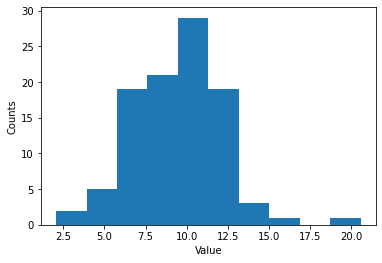

In [259]:
plt.hist(x) # using matplotlib this time
plt.xlabel("Value")
plt.ylabel("Counts")
plt.show()

Histograms simple count the number of values falling into a set of bins. 

Now with the NumPy function `histogram`.

In [260]:
np.histogram(a=x)

(array([ 2,  5, 19, 21, 29, 19,  3,  1,  0,  1]),
 array([ 2.06692914,  3.9165801 ,  5.76623106,  7.61588202,  9.46553298,
        11.31518394, 13.1648349 , 15.01448586, 16.86413682, 18.71378778,
        20.56343875]))

It returns a tuple with the `counts` and the bin `edges`.

np.histogram has a `bins` parameter to set the number and range of you bins:

* If bins is an integer: Number of bins in the histogram.
* If bins is an array:  It defines a monotonically increasing array of bin edges, 
    

In [261]:
counts,edges = np.histogram(a=x,bins=20)
print(counts)
print(edges)

[ 1  1  2  3  7 12 14  7 14 15 12  7  3  0  1  0  0  0  0  1]
[ 2.06692914  2.99175462  3.9165801   4.84140558  5.76623106  6.69105654
  7.61588202  8.5407075   9.46553298 10.39035846 11.31518394 12.24000942
 13.1648349  14.08966038 15.01448586 15.93931134 16.86413682 17.7889623
 18.71378778 19.63861327 20.56343875]


In [262]:
len(counts),len(edges)

(20, 21)

The length of `edges` is the length of `count` + 1.

To plot it, you can center the counts on the center of each bin.

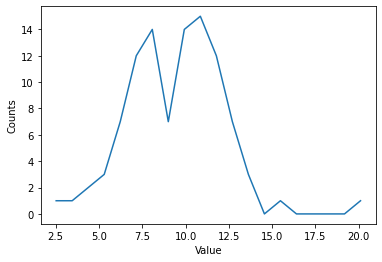

In [263]:
binWidth=edges[1]-edges[0] # width of our bins
plt.plot(edges[:-1]+binWidth/2,counts) # we add half the bin with to have the data at the center of each bin.
plt.xlabel("Value")
plt.ylabel("Counts")
plt.show()

You can specify directly the bins you want using an array containing the edges of the bins.

In [264]:
bins = np.arange(start=0,stop=21,step=1)
bins

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [265]:
counts,edges = np.histogram(a=x,bins=bins)
print(counts)
print(edges)

[ 0  0  1  2  1  4  8 17 12 10 13 19  7  3  1  1  0  0  0  0]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


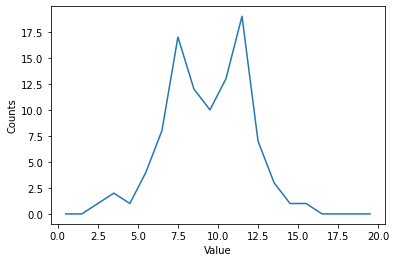

In [266]:
binWidth=edges[1]-edges[0] # width of our bins
plt.plot(edges[:-1]+binWidth/2,counts) # we add half the bin with to have the data at the center of each bin.
plt.xlabel("Value")
plt.ylabel("Counts")
plt.show()

### Back to our spike train

In [267]:
st = stList[0] # get the spike train of the first neuron in variable st

We want 1 ms bins that will cover the entire recording session (1243 seconds)

In [268]:
duration = 1243
bins = np.arange(start=0,stop=duration+0.001,step=0.001) #0.001 second is 1 ms
print(bins.shape)

(1243001,)


In [269]:
counts, edges = np.histogram(a = st,bins=bins)
print(counts.shape,edges.shape)

(1243000,) (1243001,)


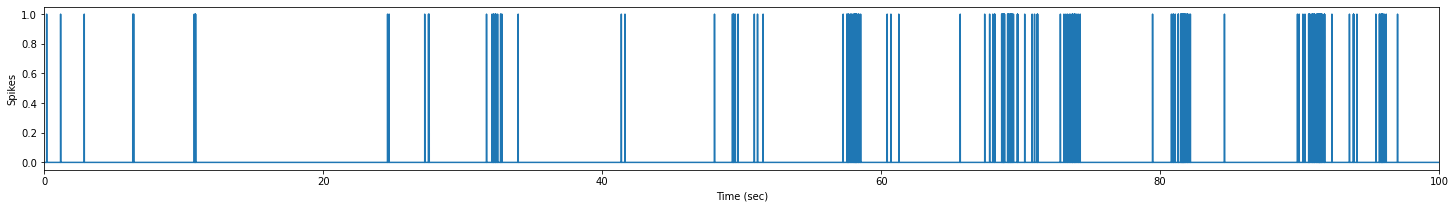

In [270]:
plt.figure(figsize=(25,3))
plt.plot(bins[1:],counts)
plt.xlim(0,100)
plt.ylabel("Spikes")
plt.xlabel("Time (sec)")
plt.show()

Because we use very small bins, we get either 0 or 1 spike per bin. 

The firing rate definition is $spikes/seconds$. To go from spike count to firing rate, you just divide the number by `time in second`.

If we have 1 spike, we get 1/0.001, which equals 1000 Hz.

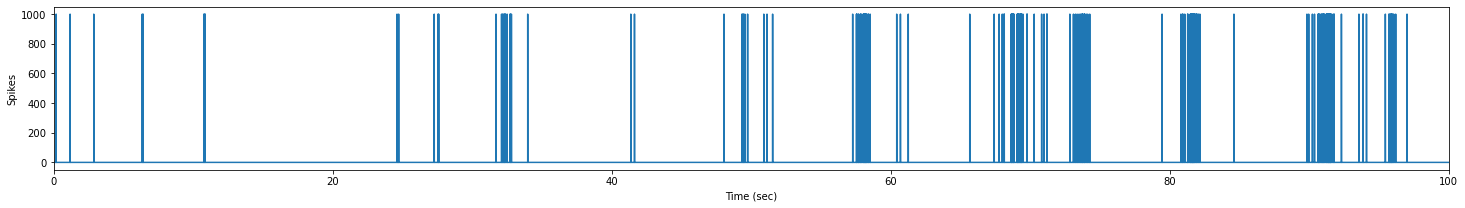

In [271]:
plt.figure(figsize=(25,3))
plt.plot(bins[1:],counts/0.001)
plt.xlim(0,100)
plt.ylabel("Spikes")
plt.xlabel("Time (sec)")
plt.show()

### Applying a gaussian filter to the spike counts

Most of the time, you want an estimate of firing rate that takes into account the number of spikes just before and after a given time point, not just 0 Hz and 1000 Hz.

To do this, we need to apply some smoothing to our data. A common technique is convolve our spike counts with a gaussian kernel (Gaussian filtering).

We create a gaussian kernel, and we perform a [convolution](https://en.wikipedia.org/wiki/Convolution) between our spike count array and the gaussian kernel.

[2 0 1 2 0 1 3 2 0 0 0]


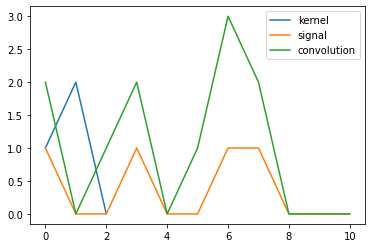

In [272]:
kernel = [1,2,0]
signal = [1,0,0,1,0,0,1,1,0,0,0]

c = np.convolve(kernel,signal,mode="same")

print(c)


# General idea in a convolution
# kernel = [1,2,0]
# signal = [1,0,0,1,0,0,1,1,0,0,0]

# one of the 2 array gets flipped in the convolution, here I flipped the kernel.

#[0,2,1]
# 0 [1,0,0,1,0,0,1,1,0,0,0]
#2*1 + 1*0 = 2

#[0,2,1]
#[1,0,0,1,0,0,1,1,0,0,0]
#0*1 + 2*0 + 1*0 = 0

#  [0,2,1]
#[0,0,0,1,0,0,1,1,0,0,0]
#0*0 + 2*0 + 1*1 = 1

#    [0,2,1]
#[0,0,0,1,0,0,1,1,0,0,0]
#0*0 + 2*1 + 1*0 = 2

#      [0,2,1]
#[0,0,0,1,0,0,1,1,0,0,0]
#0*1 + 2*0 + 1*0 = 0

#        [0,2,1]
#[0,0,0,1,0,0,1,1,0,0,0]
#0*0 + 2*0 + 1*1 = 1

#          [0,2,1]
#[0,0,0,1,0,0,1,1,0,0,0]
#0*0 + 2*1 + 1*1 = 3

#            [0,2,1]
#[0,0,0,1,0,0,1,1,0,0,0]
#0*1 + 2*1 + 1*0 = 2

#              [0,2,1]
#[0,0,0,1,0,0,1,1,0,0,0]
#0*1 + 2*0 + 1*0 = 0

#                [0,2,1]
#[0,0,0,1,0,0,1,1,0,0,0]
#0*0 + 2*0 + 1*0 = 0

#                  [0,2,1]
#[0,0,0,1,0,0,1,1,0,0,0]0
#0*0 + 2*0 + 1*0 = 0



plt.plot(kernel,label="kernel")
plt.plot(signal,label="signal")
plt.plot(c,label="convolution")
plt.legend()
plt.show()

To understand how the gaussian filter works, we will use `scipy.stats.norm` and `np.convolve`. You can just use `scipy.ndimage.filters.gaussian_filter` if you want to get the job done quickly.

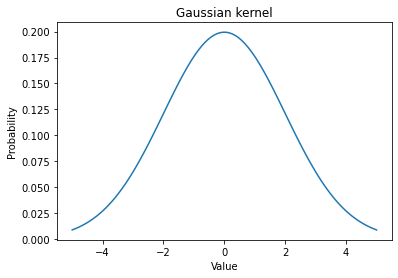

In [273]:
from scipy.stats import norm

x = np.linspace(-5,5,100)
gaussian_kernel = norm.pdf(x,loc=0,scale=2)
plt.plot(x, gaussian_kernel)
plt.xlabel("Value")
plt.ylabel("Probability")
plt.title("Gaussian kernel")
plt.show()

We can calculate the convolution of our signal (spike counts array) with our gaussian kernel

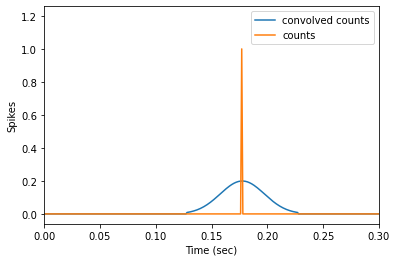

In [274]:
convCount = np.convolve(counts,gaussian_kernel,mode="same")
plt.plot(bins[1:],convCount,label="convolved counts")
plt.plot(bins[1:],counts,label="counts")
plt.xlim(0,0.3)
plt.ylabel("Spikes")
plt.xlabel("Time (sec)")
plt.legend()
plt.show()

Single spikes are now represented as a gaussian distribution. You can change the width of the gaussian kernel to change how much smoothing will be applied.

You can use [scipy.ndimage.filters.gaussian_filter](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.filters.gaussian_filter.html) to generate the kernel and do the convolution for you.

In [275]:
from scipy.ndimage.filters import gaussian_filter
ifr = gaussian_filter(counts.astype("float"),sigma=200) # you need to transform the spike count to float, sigma is the width of the gaussian kernel
ifr = ifr/0.001 # to transform to Hz

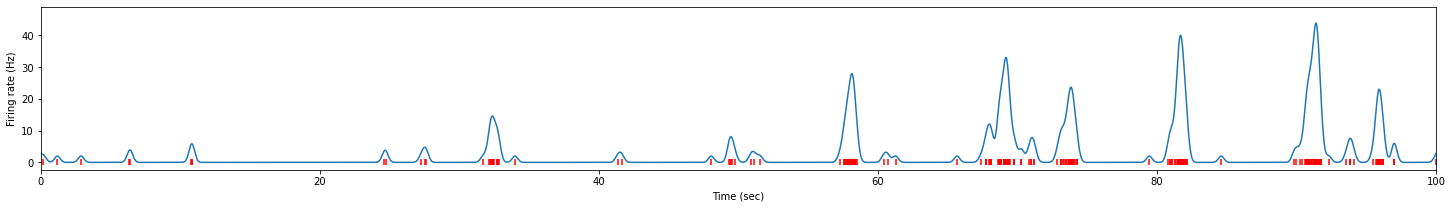

In [277]:
plt.figure(figsize=(25,3))
plt.plot(bins[1:],ifr)
plt.scatter(st,np.zeros_like(stList[0]),c="red",marker='|')
plt.xlim(0,100)
plt.ylabel("Firing rate (Hz)")
plt.xlabel("Time (sec)")
ifrBins = bins

We get a smoother instantaneous firing rate, which is integrated over time. 

This instantaneous firing rate would now be ready for analysis. For instance to calculate whether the firnig rate is linearly related to the animal speed (as we did in Lecture 4).

# Position of the animal during recordings

In the current data set, we have the position of the animal (x,y) in time. This is stored in `myData["position"]`

In [278]:
myData["position"]

{'time': array([0.00000e+00, 2.00000e-02, 4.00000e-02, ..., 1.24332e+03,
        1.24334e+03, 1.24336e+03]),
 'x': array([nan, nan, nan, ..., nan, nan, nan]),
 'y': array([nan, nan, nan, ..., nan, nan, nan])}

## Exercise 3: Plot the path of the animal (x,y).

# Firing rate map of a neuron

1. Occupancy map
2. Position of the animal associated with each spike
3. Firing rate map

## Occupancy map 

Imagine that we divide the space explored by the animal in 2x2 cm bins. The occupancy map represent the time in second that the animal spent in each bin.

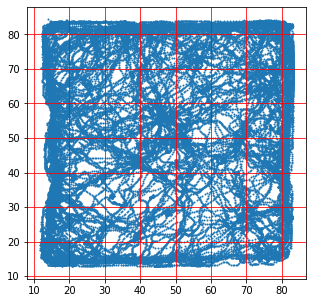

In [279]:
plt.figure(figsize=(5,5))
plt.scatter(p["x"],p["y"],s=1)
plt.grid(c="red",zorder=3)

You need to count the number of occurances in a set of bins. This is the same as calculating a histogram, but in 2D.


You can start with solving the problem in 1D and then move to 2D. 

Let's start with the x position only, and using matplotlib to see the results.

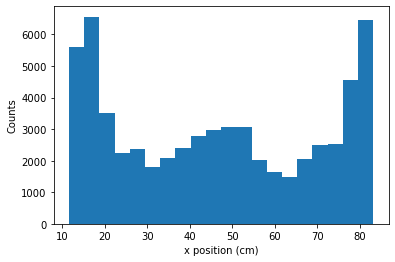

In [280]:
plt.hist(p["x"],bins=20)
plt.xlabel("x position (cm)")
plt.ylabel("Counts")
plt.show()

Now with the NumPy 

In [281]:
np.histogram(p["x"])

ValueError: autodetected range of [nan, nan] is not finite

We get this error because our data contain `np.nan`. We can either set the bins and the error message will go away.

In [282]:
binWidth=2
bins = np.arange(start=10,stop=90+2,step=binWidth)
bins

array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42,
       44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76,
       78, 80, 82, 84, 86, 88, 90])

In [283]:
np.histogram(p["x"],bins=bins)

(array([  19, 2694, 4912, 3137, 2818, 1738, 1485, 1156, 1271, 1276,  954,
        1114, 1200, 1149, 1498, 1450, 1666, 1525, 1725, 1839, 1718, 1751,
        1267, 1072,  993,  815,  815,  851, 1144, 1478, 1344, 1420, 1400,
        1978, 3259, 4513, 1278,    0,    0,    0]),
 array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42,
        44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76,
        78, 80, 82, 84, 86, 88, 90]))

In [284]:
counts, edges = np.histogram(p["x"],bins = bins)

Text(0, 0.5, 'Counts')

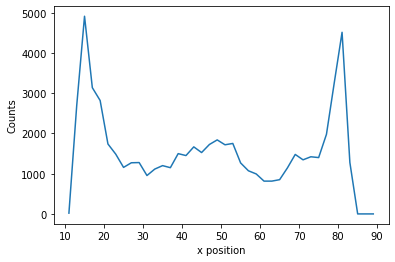

In [285]:
plt.plot(edges[:-1]+binWidth/2,counts)
plt.xlabel("x position")
plt.ylabel("Counts")

## Exercise 4: 
* Use the NumPy [histogram2d](https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html) function to create an occupancy map from the position data (x,y).
* Plot the results (2D array)

We have counts in our array but what we want is time in second.

The time interval between position data points is constant. You can get the time per position data using the code below.

In [286]:
deltaTime = p["time"][1]-p["time"][0]
print("Time per data point: {} sec".format(deltaTime))
occMap, binsx, binsy = np.histogram2d(p["x"],p["y"],bins=bins)

Time per data point: 0.02 sec


Transform the values from counts to seconds.

In [287]:
occMap = occMap*deltaTime

We could set the bins that are never visited by the animal (time of 0 second) to np.nan

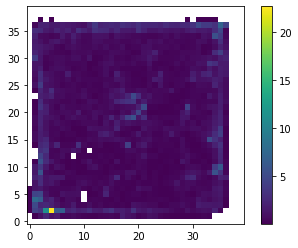

In [288]:
occMapNan = occMap.copy()
occMapNan[occMapNan==0.0] = np.nan

plt.imshow(occMapNan.T,origin="lower")
plt.colorbar()
plt.show()


## Position of the animal associated with each spike

We have the position of the animal at fixed time intervals. 

We need to find the x and y position of the animal at specific time points, which likely fall between our position data points.

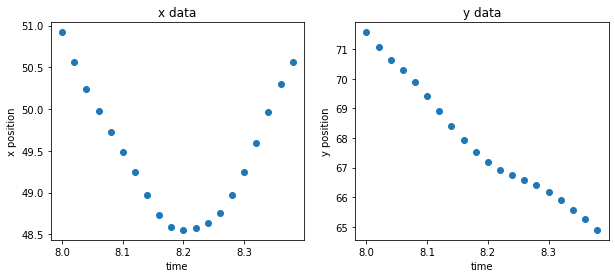

In [289]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].scatter(p["time"][400:420],p["x"][400:420])
ax[0].set_xlabel("time")
ax[0].set_ylabel("x position")
ax[0].set_title("x data")

ax[1].scatter(p["time"][400:420],p["y"][400:420])
ax[1].set_xlabel("time")
ax[1].set_ylabel("y position")
ax[1].set_title("y data")

plt.show()

We can use **linear interpolation** to do this.

Scipy has a few interpolation functions: [scipy.interpolate.interp1d()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html)

Here is just an example to show that we can get the position at any time point using interpolation.

In [290]:
from scipy.interpolate import interp1d

newTime = np.linspace(0,10,10000) # times at which we would like to know the x position of the animal

fx = interp1d(p["time"], p["x"]) # create function that will interpolate

xOfNewTime = fx(newTime) # interpolate

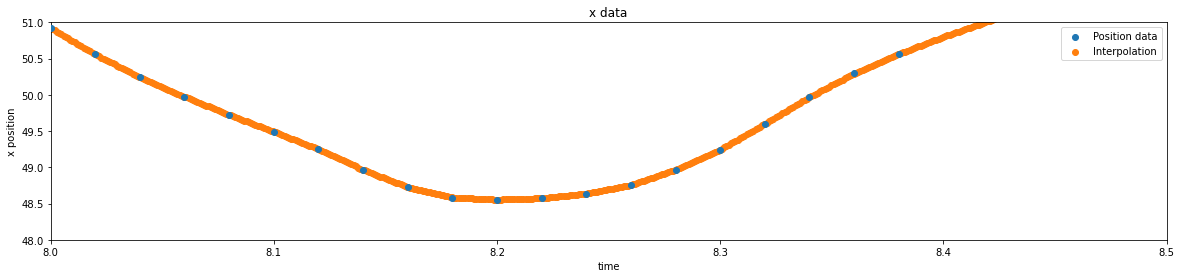

In [291]:
fig, ax = plt.subplots(1,1,figsize=(20,4))

ax.scatter(p["time"][400:420],p["x"][400:420], zorder=3, label="Position data")
ax.scatter(newTime,xOfNewTime,zorder=2,label="Interpolation")
ax.set_xlim(8,8.5)
ax.set_ylim(48,51)
ax.set_xlabel("time")
ax.set_ylabel("x position")
ax.set_title("x data")
ax.legend()
plt.show()

We could get the position at any time point using linear interpolation.

## Exercise 5

Get the x and y position of the animal for the spike of the third neuron (`myData["spike_trains"][3]`). Plot the position of each spike.

Do you notice anything particular about the firing pattern of this neuron?

## Firing rate map of a neuron

A firing rate map contains the firing rate of a neuron at different locations (bins).

The firing rate is defined as the number of spikes per second (Hz).

$Rate = spikes/sec$

The occupancy map contains the time in seconds at different locations. 

All we need is the number of spikes in these same bins. We can use the NumPy function `histogram2d` to get the spike counts in bins.

In [292]:
fx = interp1d(p["time"], p["x"]) # create function that will interpolate
fy = interp1d(p["time"], p["y"]) # create function that will interpolate
spikeX = fx(st)
spikeY = fy(st)

nSpikes, binsx, binsy = np.histogram2d(spikeX,spikeY,bins=bins)

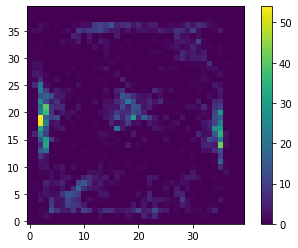

In [293]:
plt.imshow(nSpikes.T,origin="lower")
plt.colorbar()
plt.show()

In [294]:
firingRateMap = nSpikes/occMapNan

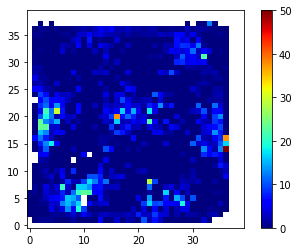

In [295]:
plt.imshow(firingRateMap.T,origin="lower",cmap="jet")
plt.colorbar()
plt.show()

## Applying smoothing to the firing rate map

Because the recording period is not very long (20 minutes), there is considerable "noise" in our estimate of firing rate. We can apply a Gaussian filter to smooth the map. 

In [296]:
from scipy.ndimage.filters import gaussian_filter
    
sOccMap = gaussian_filter(occMap, sigma=1.5)
snSpikes = gaussian_filter(nSpikes, sigma=1.5)

Text(0.5, 1.0, 'Smoothed spike count')

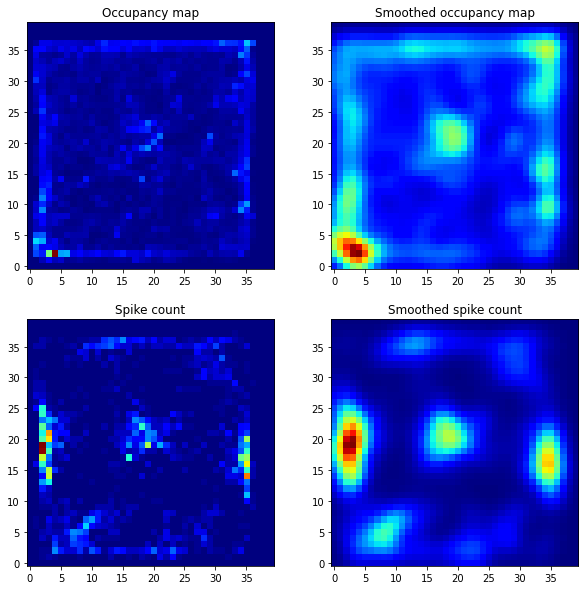

In [297]:
fig,ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].imshow(occMap.T,origin="lower",cmap="jet")
ax[0,0].set_title("Occupancy map")
ax[0,1].imshow(sOccMap.T,origin="lower",cmap="jet")
ax[0,1].set_title("Smoothed occupancy map")

ax[1,0].imshow(nSpikes.T,origin="lower",cmap="jet")
ax[1,0].set_title("Spike count")
ax[1,1].imshow(snSpikes.T,origin="lower",cmap="jet")
ax[1,1].set_title("Smoothed spike count")

In [298]:
sOccMap[occMap==0.0] = np.nan # remove the values that were 0 in the occupancy map before smoothing

sFiringRateMap = snSpikes/sOccMap


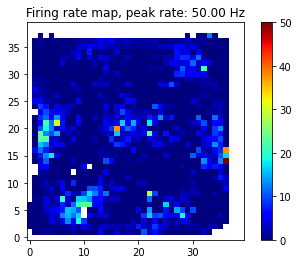

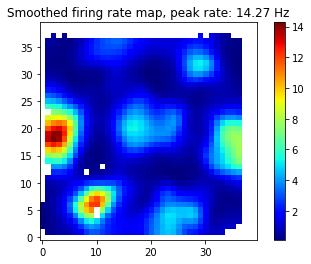

In [299]:
plt.imshow(firingRateMap.T,origin="lower",cmap="jet")
plt.colorbar()
plt.title("Firing rate map, peak rate: {:.2f} Hz".format(np.nanmax(firingRateMap)))
plt.show()

plt.imshow(sFiringRateMap.T,origin="lower",cmap="jet")
plt.colorbar()
plt.title("Smoothed firing rate map, peak rate: {:.2f} Hz".format(np.nanmax(sFiringRateMap)))
plt.show()

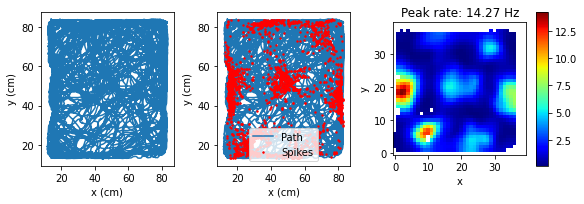

In [304]:
import matplotlib.gridspec as gridspec


fig = plt.figure(constrained_layout=True,figsize=(8,5))
gs = fig.add_gridspec(2, 3)


ax = fig.add_subplot(gs[1,:])



ax = fig.add_subplot(gs[1,0])
ax.plot(p["x"],p["y"],label="Path")
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")

ax = fig.add_subplot(gs[1,1])
ax.plot(p["x"],p["y"],label="Path")
ax.scatter(spikeX,spikeY,s=2,c="red",zorder=3,label="Spikes")
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")
ax.legend()


ax = fig.add_subplot(gs[1,2])
im = ax.imshow(sFiringRateMap.T,origin="lower",cmap="jet")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Peak rate: {:.2f} Hz".format(np.nanmax(sFiringRateMap)))
plt.colorbar(im)



fn = "../images/gridCellExample.png"
plt.savefig(fn)
plt.show()